# Simulation to show how the dormand prince method can be parallelized

In [107]:
import numpy as np
import matplotlib.pyplot as plt
import time
import colorsys
# %matplotlib qt
%matplotlib inline

## Utils

### Task

In [108]:
class TaskType:
    INDEPENDENT = 0
    DEPENDENT = 1
    VECTOR_MULT = 2


class Task:

    step: int
    task_type: int
    start_time: int
    end_time: int

    def __init__(self, step, task_type):
        self.step = step
        self.task_type = task_type
        self.start_time = time.perf_counter_ns()

    def __copy__(self):
        t = Task(self.step, self.task_type)
        t.start_time = self.start_time
        t.end_time = self.end_time
        return t
    
    def set_start_time(self, start_time):
        self.end_time = start_time + self.end_time - self.start_time
        self.start_time = start_time
        

    def end(self):
        self.end_time = time.perf_counter_ns()

    def __str__(self):
        return f"Task(step={self.step}, type={self.task_type}, start_time={self.start_time}, end_time={self.end_time})"

### Scheduling tree

In [109]:
class SchedulingTree:

    class Node:
        def __init__(self, task):
            self.task = task
            self.left = None
            self.right = None
    

    def __init__(self):
        self.root = None


    # Return the earliest start time for a task for a given duration that does not overlap with any other task
    def schedule(self, wanted_start, task):
        return self._schedule(self.root, wanted_start, task)

    def _schedule(self, node, wanted_start, task):
        if node is None:
            return wanted_start
        
        # |-Current node-|  |-My task-|
        if wanted_start >= node.task.end_time:
            return wanted_start
        
        duration = task.end_time - task.start_time

        # Check if is a leaf
        if node.left is None and node.right is None:
            # Leaf
            if wanted_start + duration <= node.task.start_time:
                return wanted_start
            else:
                return node.task.end_time
        else:
            # Not leaf
            wanted_start = self._schedule(node.left, wanted_start, task)
            return self._schedule(node.right, wanted_start, task)
    

    def add(self, start, task):
        t = task.__copy__()
        t.set_start_time(start)
        self.root = self._add(self.root, t)

    def _add(self, node, task):
        if node is None:
            return self.Node(task)
        
        # Check if is a leaf
        if node.left is None and node.right is None:
            # Leaf
            if task.start_time < node.task.start_time:
                node.left = self.Node(task)
                node.right = self.Node(node.task.__copy__())
                node.task.start_time = task.start_time
            else:
                node.left = self.Node(node.task.__copy__())
                node.right = self.Node(task)
                node.task.end_time = task.end_time
        else:
            # Node
            if task.start_time < node.right.task.start_time:
                node.left = self._add(node.left, task)
                node.task.start_time = min(node.task.start_time, task.start_time)
            else:
                node.right = self._add(node.right, task)
                node.task.end_time = max(node.task.end_time, task.end_time)
        
        return node


    # Depth first with only leafs
    def get_schedule(self):
        return self._get_schedule(self.root, [])


    def _get_schedule(self, node, schedule):
        if node is None:
            return schedule
        
        # Check if is a leaf
        if node.left is None and node.right is None:
            # Leaf
            schedule.append(node.task)
        else:
            self._get_schedule(node.left, schedule)
            self._get_schedule(node.right, schedule)
        
        return schedule
    

    def __str__(self):
        return str(self.get_schedule())


schedule = SchedulingTree()
t = Task(1, TaskType.DEPENDENT)
t.start_time = 10
t.end_time = 20
start = schedule.schedule(10, t)
print(start)
schedule.add(start, t)
print(schedule)

t = Task(2, TaskType.DEPENDENT)
t.start_time = 20
t.end_time = 40
start = schedule.schedule(5, t)
print(start)
schedule.add(start, t)
print(schedule)

t = Task(3, TaskType.DEPENDENT)
t.start_time = 40
t.end_time = 50
start = schedule.schedule(0, t)
print(start)
schedule.add(start, t)
print(schedule)

10
20
[<__main__.Task object at 0x000001D1B2676590>, <__main__.Task object at 0x000001D1B66A6990>]
0
[<__main__.Task object at 0x000001D1B5F88490>, <__main__.Task object at 0x000001D1B6680450>, <__main__.Task object at 0x000001D1B66A6990>]


### Logger

In [110]:
class Logger:

    tasks: list

    def __init__(self):
        self.tasks = []

    def __call__(self, step, task_type):
        if len(self.tasks) > 0:
            self.tasks[-1].end()
        self.tasks.append(Task(step, task_type))

    def close(self):
        if self.tasks[-1] is not None:
            self.tasks[-1].end()

    def __str__(self):
        return "\n".join([f"Step {task.step} - {task.task_type} - {task.end_time - task.start_time}"
            for task in self.tasks])


    def simulate(self, thread_count=4):
        
        def schedule_on_thread(threads, start, task):
            # Iterate over threads
            thread = 0
            best_start = threads[thread].schedule(start, task)
            for i in range(1,len(threads)):
                # Find the best start time
                s = threads[i].schedule(start, task)
                if s < best_start:
                    best_start = s
                    thread = i
            threads[thread].add(best_start, task)
            return best_start
        
        def schedule_on_mult_thread(threads, start, task, thread_count):
            # Iterate over threads
            start_time = []
            ids =np.linspace(0, thread_count)
            sub_task = task.__copy__()
            duration = (task.end_time - task.start_time) / thread_count
            sub_task.end_time = sub_task.start_time + duration
            for i in range(thread_count):
                start_time.append(schedule_on_thread(threads, start, sub_task))
            
            # Sort by start time and ids by start time
            # start_time, ids = zip(*sorted(zip(start_time, ids)))
            for i in range(thread_count):
                threads[i].add(start_time[i], sub_task)
            return start_time[0], start_time[thread_count - 1] + duration

            


        offset = self.tasks[0].start_time
        dependent_time = 0
        threads = [SchedulingTree() for _ in range(thread_count)]

        for task in self.tasks:
            if task.task_type == TaskType.INDEPENDENT:
                start_time = schedule_on_thread(threads, 0, task)
                dependent_time = max(dependent_time, start_time + task.end_time - task.start_time)
            elif task.task_type == TaskType.VECTOR_MULT:
                start_time, end_time = schedule_on_mult_thread(threads, dependent_time, task, 3)
                dependent_time = end_time
            else:
                start_time = schedule_on_thread(threads, dependent_time, task)
                dependent_time = start_time + task.end_time - task.start_time

        return threads


    def show(self):

        
        # Step over time graph labelled by task type
        def step_over_time_by_task_type(graph, tasks):
            offset = self.tasks[0].start_time
            graph.set_title("Step execution as captured")
            graph.set_ylabel("Step")
            graph.set_xlabel("Time (tick)")

            t = tasks.copy()
            t.sort(key=lambda x: x.step, reverse=True)

            added_labels = set()
            for task in t:
                color = "black"
                label = "Unknown"
                if task.task_type == TaskType.INDEPENDENT:
                    color = "blue"
                    label = "Independent"
                elif task.task_type == TaskType.DEPENDENT:
                    color = "red"
                    label = "Dependent"
                elif task.task_type == TaskType.VECTOR_MULT:
                    color = "green"
                    label = "Vector mult"

                start = task.start_time - offset
                duration = task.end_time - task.start_time
                name = f"#{task.step}"
                if label not in added_labels:
                    graph.plot([start, start+duration], [name, name], color=color, linewidth=line_width, solid_capstyle='butt', label=label)
                    added_labels.add(label)
                else:
                    graph.plot([start, start+duration], [name, name], color=color, linewidth=line_width, solid_capstyle='butt')
            graph.legend()


        # Step over time graph labelled by task type
        def step_over_time_by_task_type_no_dead_time(graph, tasks):
            graph.set_title("Step execution without dead time")
            graph.set_ylabel("Step")
            graph.set_xlabel("Time (tick)")

            t = tasks.copy()
            t.sort(key=lambda x: x.step, reverse=False)
            last_end = 0
            for task in t:
                task.end_time = last_end + task.end_time - task.start_time
                task.start_time = last_end
                last_end = task.end_time
            t.sort(key=lambda x: x.step, reverse=True)

            added_labels = set()
            for task in t:
                color = "black"
                label = "Unknown"
                if task.task_type == TaskType.INDEPENDENT:
                    color = "blue"
                    label = "Independent"
                elif task.task_type == TaskType.DEPENDENT:
                    color = "red"
                    label = "Dependent"
                elif task.task_type == TaskType.VECTOR_MULT:
                    color = "green"
                    label = "Vector mult"

                start = task.start_time
                duration = task.end_time - task.start_time
                name = f"#{task.step}"
                if label not in added_labels:
                    graph.plot([start, start+duration], [name, name], color=color, linewidth=line_width, solid_capstyle='butt', label=label)
                    added_labels.add(label)
                else:
                    graph.plot([start, start+duration], [name, name], color=color, linewidth=line_width, solid_capstyle='butt')
            graph.legend()


        # Thread over time graph labelled by step
        def thread_over_time_by_step(graph, ocupation):
            graph.set_title("Thread execution")
            graph.set_ylabel("Thread")
            graph.set_xlabel("Time (tick)")
            added_labels = set()
            for i, thread in enumerate(ocupation):
                for task in thread.get_schedule():
                    name = f"#{i}"
                    # Color using HSL color space for the step id
                    color = colorsys.hls_to_rgb(task.step * 0.15, 0.5, 1)
                    label = f"Step #{task.step}"
                    if label not in added_labels:
                        graph.plot([task.start_time, task.end_time], [name, name], color=color, label=label, linewidth=line_width, solid_capstyle='butt')
                        added_labels.add(label)
                    else:
                        graph.plot([task.start_time, task.end_time], [name, name], color=color, linewidth=line_width, solid_capstyle='butt')
            graph.legend()


        # Thread over time graph labelled by task type
        def thread_over_time_by_task_type(graph, ocupation):
            graph.set_title("Thread execution")
            graph.set_ylabel("Thread")
            graph.set_xlabel("Time (tick)")
            added_labels = set()
            for i, thread in enumerate(ocupation):
                for task in thread.get_schedule():
                    color = "black"
                    label = "Unknown"
                    if task.task_type == TaskType.INDEPENDENT:
                        color = "blue"
                        label = "Independent"
                    elif task.task_type == TaskType.DEPENDENT:
                        color = "red"
                        label = "Dependent"
                    elif task.task_type == TaskType.VECTOR_MULT:
                        color = "green"
                        label = "Vector mult"
                    name = f"#{i}"
                    if label not in added_labels:
                        graph.plot([task.start_time, task.end_time], [name, name], color=color, label=label, linewidth=line_width, solid_capstyle='butt')
                        added_labels.add(label)
                    else:
                        graph.plot([task.start_time, task.end_time], [name, name], color=color, linewidth=line_width, solid_capstyle='butt')
            graph.legend()


        # Step over time graph labelled by thread
        def step_over_time_by_thread(graph, ocupation):
            graph.set_title("Step execution reworked")
            graph.set_xlabel("Time (tick)")
            graph.set_ylabel("Step")
            added_labels = set()
            
            for i, thread in enumerate(ocupation):
                ts = thread.get_schedule()
                ts = sorted(ts, key=lambda x: x.start_time, reverse=True)
                for task in ts:
                    name = f"#{task.step}"
                    # Color using HSL color space for the step id
                    color = colorsys.hls_to_rgb(i * 0.15, 0.5, 1)
                    label = f"Thread #{i}"
                    if label not in added_labels:
                        graph.plot([task.start_time, task.end_time], [name, name], color=color, label=label, linewidth=line_width, solid_capstyle='butt')
                        added_labels.add(label)
                    else:
                        graph.plot([task.start_time, task.end_time], [name,name], color=color, linewidth=line_width, solid_capstyle='butt')
            graph.legend()


        line_width = 15
        # font_size_label = 20
        # font_size_title = 30
        threads_ocupation = self.simulate()
        fig = plt.figure(figsize=(15, 20))
        #  fig, (_, _, bx1, bx2, cx1) = plt.subplots(5, 1, sharex=True, figsize=(15, 20))
        fig.subplots_adjust(hspace=0.5)

        # Step over time graph labelled by task type
        ax1 = fig.add_subplot(5, 1, 1)
        step_over_time_by_task_type(ax1, self.tasks)

        # Step over time graph labelled by task type
        ax2 = fig.add_subplot(5, 1, 2)
        step_over_time_by_task_type_no_dead_time(ax2, self.tasks)

        # Thread over time graph labelled by step
        bx1 = fig.add_subplot(5, 1, 3, sharex=fig.axes[1])
        thread_over_time_by_step(bx1, threads_ocupation)

        # Thread over time graph labelled by task type
        bx2 = fig.add_subplot(5, 1, 4, sharex=fig.axes[1])
        thread_over_time_by_task_type(bx2, threads_ocupation)

        # Step over time graph labelled by thread
        cx1 = fig.add_subplot(5, 1, 5, sharex=fig.axes[1])
        step_over_time_by_thread(cx1, threads_ocupation)

        plt.rcParams.update({
            'font.size': 12,
            'font.family': 'Arial',
            })
        plt.show()
        
    def __repr__(self):
        self.show()
        return self.__str__()


In [111]:
l = Logger()
l(0, TaskType.INDEPENDENT)
time.sleep(1)
l(0, TaskType.DEPENDENT)
time.sleep(2)
l.close()
print(l)


Step 0 - 0 - 1000838800
Step 0 - 1 - 2000759400


## Dormand Prince method

In [112]:
# Vector mutiplication
def axpy(a, x, y):
    for i in range(len(x)):
        y[i] = a * x[i] + y[i]
    return y

# Constants
a11 = 1/5

a21 = 3/40
a22 = 9/40

a31 = 44/45
a32 = -56/15
a33 = 32/9

a41 = 19372/6561
a42 = -25360/2187
a43 = 64448/6561
a44 = -212/729

a51 = 9017/3168
a52 = -355/33
a53 = 46732/5247
a54 = 49/176
a55 = -5103/18656

a61 = 35/384
a62 = 0
a63 = 500/1113
a64 = 125/192
a65 = -2187/6784
a66 = 11/84

d71 = a61 - 5179/57600
d72 = 0
d73 = a63 - 7571/16695
d74 = a64 - 393/640
d75 = a65 - 92097/339200
d76 = a66 - 187/2100
d77 = -1/40

c71 = 6025192743/30085553152
c72 = 0
c73 = 51252292925/65400821598
c74 = -2691868925/45128329728
c75 = 187940372067/1594534317056
c76 = -1776094331/19743644256
c77 = 11237099/235043384

# Stepper
def dormandPrinceLegacy(step, beg_state, equation, logger):

    # First step
    logger(1, TaskType.DEPENDENT)
    k1 = equation(*beg_state)
    state = beg_state
    axpy(step * a11, k1, state)

    # Second step
    logger(2, TaskType.DEPENDENT)
    k2 = equation(*state)
    state = beg_state
    axpy(step * a21, k1, state)
    axpy(step * a22, k2, state)

    # Third step
    logger(3, TaskType.DEPENDENT)
    k3 = equation(*state)
    state = beg_state
    axpy(step * a31, k1, state)
    axpy(step * a32, k2, state)
    axpy(step * a33, k3, state)

    # Fourth step
    logger(4, TaskType.DEPENDENT)
    k4 = equation(*state)
    state = beg_state
    axpy(step * a41, k1, state)
    axpy(step * a42, k2, state)
    axpy(step * a43, k3, state)
    axpy(step * a44, k4, state)

    # Fifth step
    logger(5, TaskType.DEPENDENT)
    k5 = equation(*state)
    state = beg_state
    axpy(step * a51, k1, state)
    axpy(step * a52, k2, state)
    axpy(step * a53, k3, state)
    axpy(step * a54, k4, state)
    axpy(step * a55, k5, state)

    # Sixth step
    logger(6, TaskType.DEPENDENT)
    k6 = equation(*state)
    result_state = beg_state
    axpy(step * a61, k1, result_state)
    axpy(step * a63, k3, result_state)
    axpy(step * a64, k4, result_state)
    axpy(step * a65, k5, result_state)
    axpy(step * a66, k6, result_state)

    # Seventh step
    logger(7, TaskType.DEPENDENT)
    k7 = equation(*result_state)

    # Error estimate
    logger(8, TaskType.DEPENDENT)
    error_state = [[0, 0, 0], [0, 0, 0]]
    axpy(step * d71, k1, error_state[0])
    axpy(step * d73, k3, error_state[0])
    axpy(step * d74, k4, error_state[0])
    axpy(step * d75, k5, error_state[0])
    axpy(step * d76, k6, error_state[0])
    axpy(step * d77, k7, error_state[0])

    # Mid point
    logger(9, TaskType.DEPENDENT)
    half_step = step / 2
    mid_state = beg_state
    axpy(half_step * c71, k1, mid_state)
    axpy(half_step * c73, k3, mid_state)
    axpy(half_step * c74, k4, mid_state)
    axpy(half_step * c75, k5, mid_state)
    axpy(half_step * c76, k6, mid_state)
    axpy(half_step * c77, k7, mid_state)

    logger.close()
    return result_state, error_state, mid_state


def dormandPrinceIsolated(step, beg_state, equation, logger):

    # First step
    logger(1, TaskType.DEPENDENT)
    k1 = equation(*beg_state)
    state = beg_state
    logger(1, TaskType.INDEPENDENT)
    coef_a11 = step * a11
    logger(1, TaskType.VECTOR_MULT)
    axpy(coef_a11, k1, state)

    # Second step
    logger(2, TaskType.DEPENDENT)
    k2 = equation(*state)
    state = beg_state
    logger(2, TaskType.INDEPENDENT)
    coef_a21 = step * a21
    coef_a22 = step * a22
    logger(2, TaskType.VECTOR_MULT)
    axpy(coef_a21, k1, state)
    axpy(coef_a22, k2, state)

    # Third step
    logger(3, TaskType.DEPENDENT)
    k3 = equation(*state)
    state = beg_state
    logger(3, TaskType.INDEPENDENT)
    coef_a31 = step * a31
    coef_a32 = step * a32
    coef_a33 = step * a33
    logger(3, TaskType.VECTOR_MULT)
    axpy(coef_a31, k1, state)
    axpy(coef_a32, k2, state)
    axpy(coef_a33, k3, state)

    # Fourth step
    logger(4, TaskType.DEPENDENT)
    k4 = equation(*state)
    state = beg_state
    logger(4, TaskType.INDEPENDENT)
    coef_a41 = step * a41
    coef_a42 = step * a42
    coef_a43 = step * a43
    coef_a44 = step * a44
    logger(4, TaskType.VECTOR_MULT)
    axpy(coef_a41, k1, state)
    axpy(coef_a42, k2, state)
    axpy(coef_a43, k3, state)
    axpy(coef_a44, k4, state)

    # Fifth step
    logger(5, TaskType.DEPENDENT)
    k5 = equation(*state)
    state = beg_state
    logger(5, TaskType.INDEPENDENT)
    coef_a51 = step * a51
    coef_a52 = step * a52
    coef_a53 = step * a53
    coef_a54 = step * a54
    coef_a55 = step * a55
    logger(5, TaskType.VECTOR_MULT)
    axpy(coef_a51, k1, state)
    axpy(coef_a52, k2, state)
    axpy(coef_a53, k3, state)
    axpy(coef_a54, k4, state)
    axpy(coef_a55, k5, state)

    # Sixth step
    logger(6, TaskType.DEPENDENT)
    k6 = equation(*state)
    result_state = beg_state
    logger(6, TaskType.INDEPENDENT)
    coef_a61 = step * a61
    coef_a63 = step * a63
    coef_a64 = step * a64
    coef_a65 = step * a65
    coef_a66 = step * a66
    logger(6, TaskType.VECTOR_MULT)
    axpy(coef_a61, k1, result_state)
    axpy(coef_a63, k3, result_state)
    axpy(coef_a64, k4, result_state)
    axpy(coef_a65, k5, result_state)
    axpy(coef_a66, k6, result_state)

    # Seventh step
    logger(7, TaskType.DEPENDENT)
    k7 = equation(*result_state)

    # Error estimate
    logger(8, TaskType.DEPENDENT)
    error_state = [[0, 0, 0], [0, 0, 0]]
    logger(8, TaskType.INDEPENDENT)
    coef_d71 = step * d71
    coef_d73 = step * d73
    coef_d74 = step * d74
    coef_d75 = step * d75
    coef_d76 = step * d76
    coef_d77 = step * d77
    logger(8, TaskType.VECTOR_MULT)
    axpy(coef_d71, k1, error_state[0])
    axpy(coef_d73, k3, error_state[0])
    axpy(coef_d74, k4, error_state[0])
    axpy(coef_d75, k5, error_state[0])
    axpy(coef_d76, k6, error_state[0])
    axpy(coef_d77, k7, error_state[0])

    # Mid point
    logger(9, TaskType.DEPENDENT)
    half_step = step / 2
    mid_state = beg_state
    logger(9, TaskType.INDEPENDENT)
    coef_c71 = half_step * c71
    coef_c73 = half_step * c73
    coef_c74 = half_step * c74
    coef_c75 = half_step * c75
    coef_c76 = half_step * c76
    coef_c77 = half_step * c77
    logger(9, TaskType.VECTOR_MULT)
    axpy(coef_c71, k1, mid_state)
    axpy(coef_c73, k3, mid_state)
    axpy(coef_c74, k4, mid_state)
    axpy(coef_c75, k5, mid_state)
    axpy(coef_c76, k6, mid_state)
    axpy(coef_c77, k7, mid_state)

    logger.close()
    return result_state, error_state, mid_state




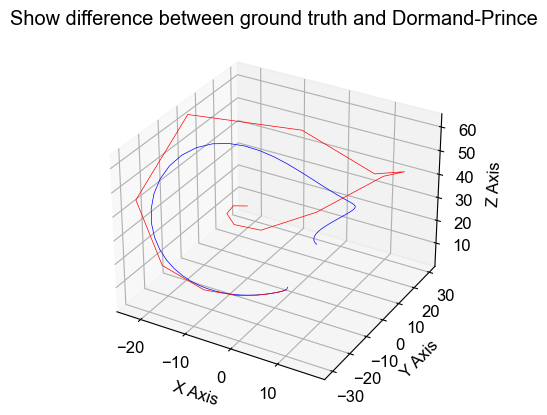

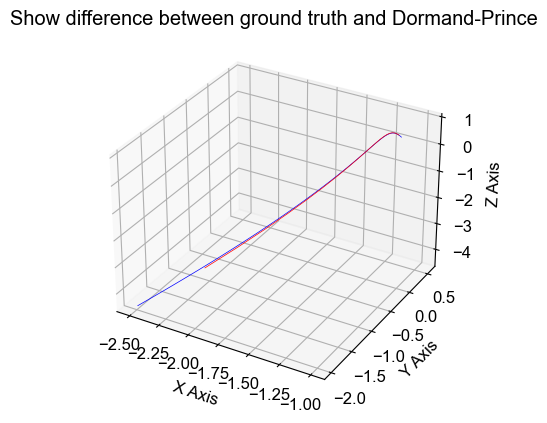

In [113]:
def lorenz(x, y, z):
    sigma = 10
    rho = 28
    beta = 8/3
    return np.array([sigma * (y - x), x * (rho - z) - y, x * y - beta * z])

def simple(x, y, z):
    return np.array([x+y, y+2*z, z+3*x])

def main(equ):
    start_state = [-1, 0, 1]
    nb_steps = 100
    dt = 0.01
    logger = Logger()

    ground_truth = np.empty((nb_steps + 1, 3))
    dp_result = np.empty((nb_steps + 1, 3))
    ground_truth[0] = start_state
    dp_result[0] = start_state

    for i in range(nb_steps):
        ground_truth[i + 1] = ground_truth[i] + equ(*ground_truth[i]) * dt
        dp_result[i + 1], _, _ = dormandPrinceIsolated(dt, dp_result[i], equ, logger)

    # Plot
    ax = plt.figure().add_subplot(projection='3d')

    ax.plot(*ground_truth.T, lw=0.5, color='b', label='Ground Truth')
    ax.plot(*dp_result[:nb_steps//5].T, lw=0.5, color='r', label='Dormand-Prince')
    ax.set_xlabel("X Axis")
    ax.set_ylabel("Y Axis")
    ax.set_zlabel("Z Axis")
    ax.set_title("Show difference between ground truth and Dormand-Prince")

    plt.show()

main(lorenz)
main(simple)

## Analysis

### Legacy

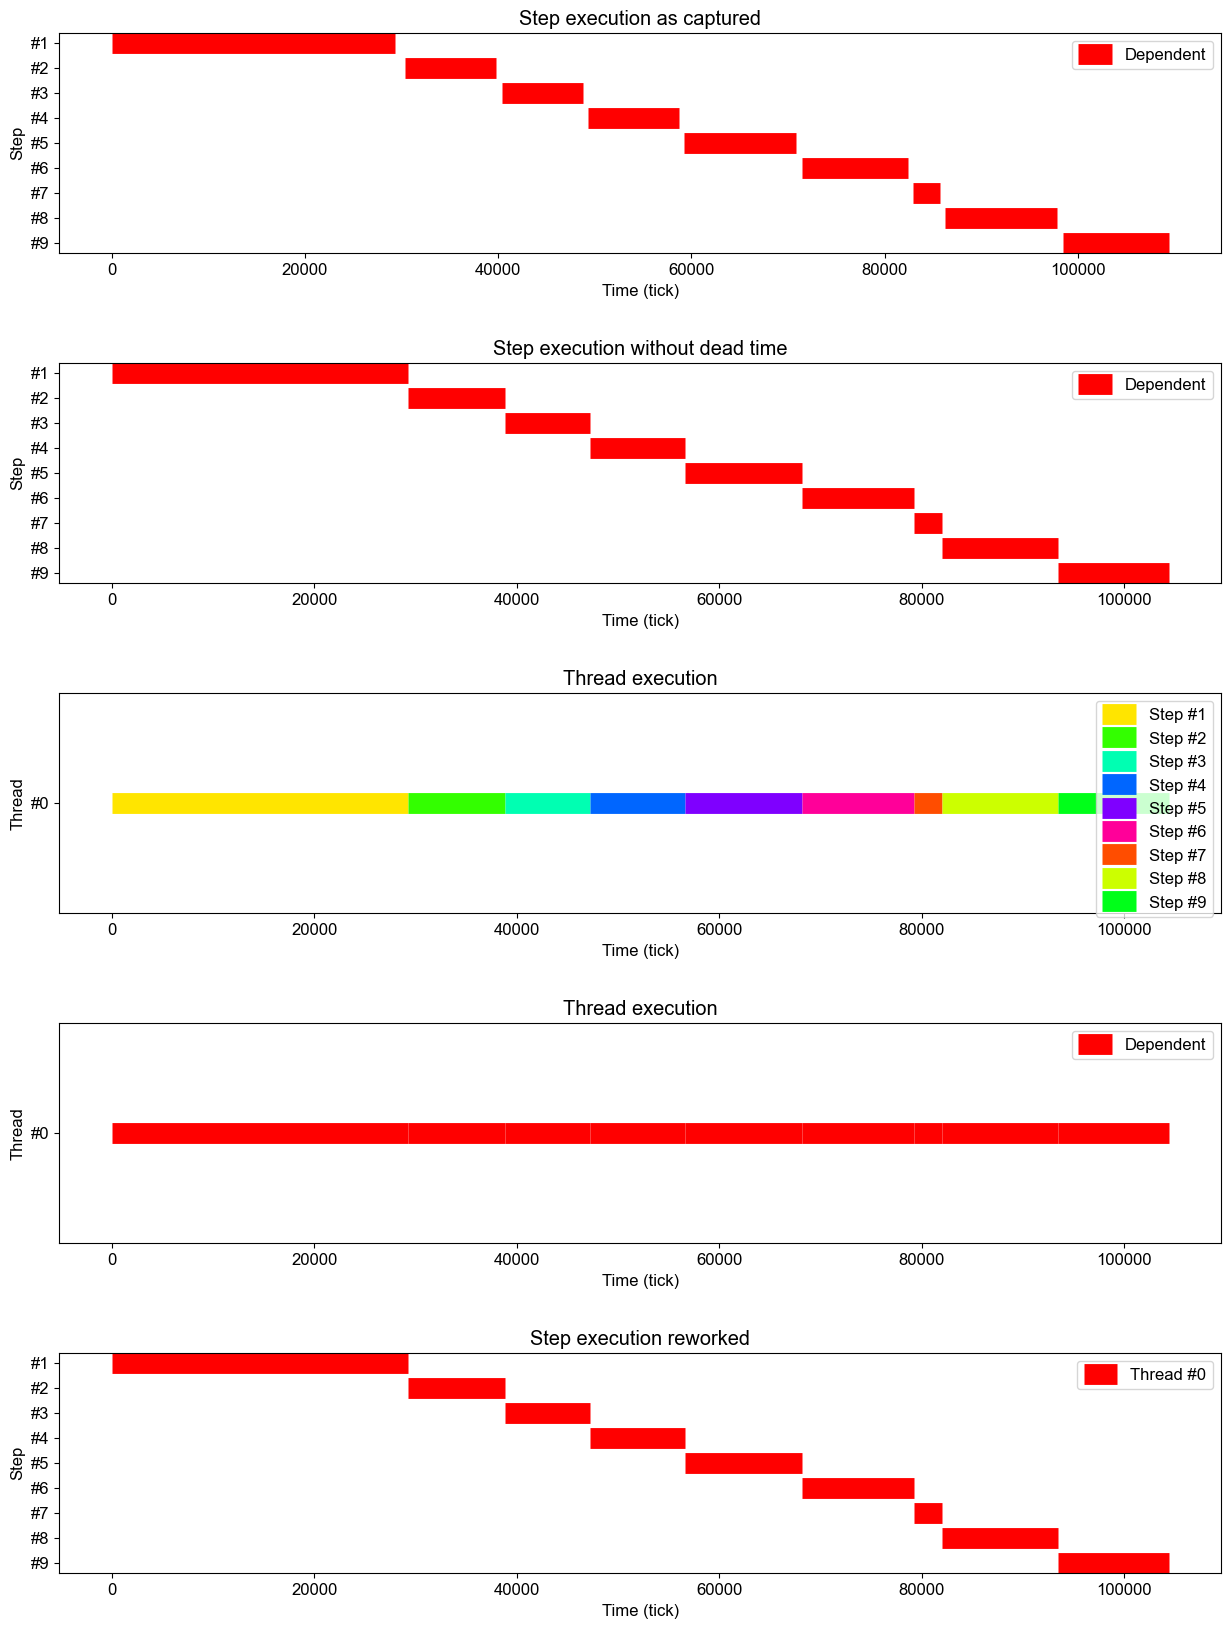

Step 1 - 1 - 29300
Step 2 - 1 - 9500
Step 3 - 1 - 8400
Step 4 - 1 - 9400
Step 5 - 1 - 11600
Step 6 - 1 - 11000
Step 7 - 1 - 2800
Step 8 - 1 - 11500
Step 9 - 1 - 10900

In [114]:
start_state = [0.1, 0.1, 0.1]
step = 1

old_logger = Logger()
dormandPrinceLegacy(step, start_state, lorenz, old_logger)
old_logger

### Isolated

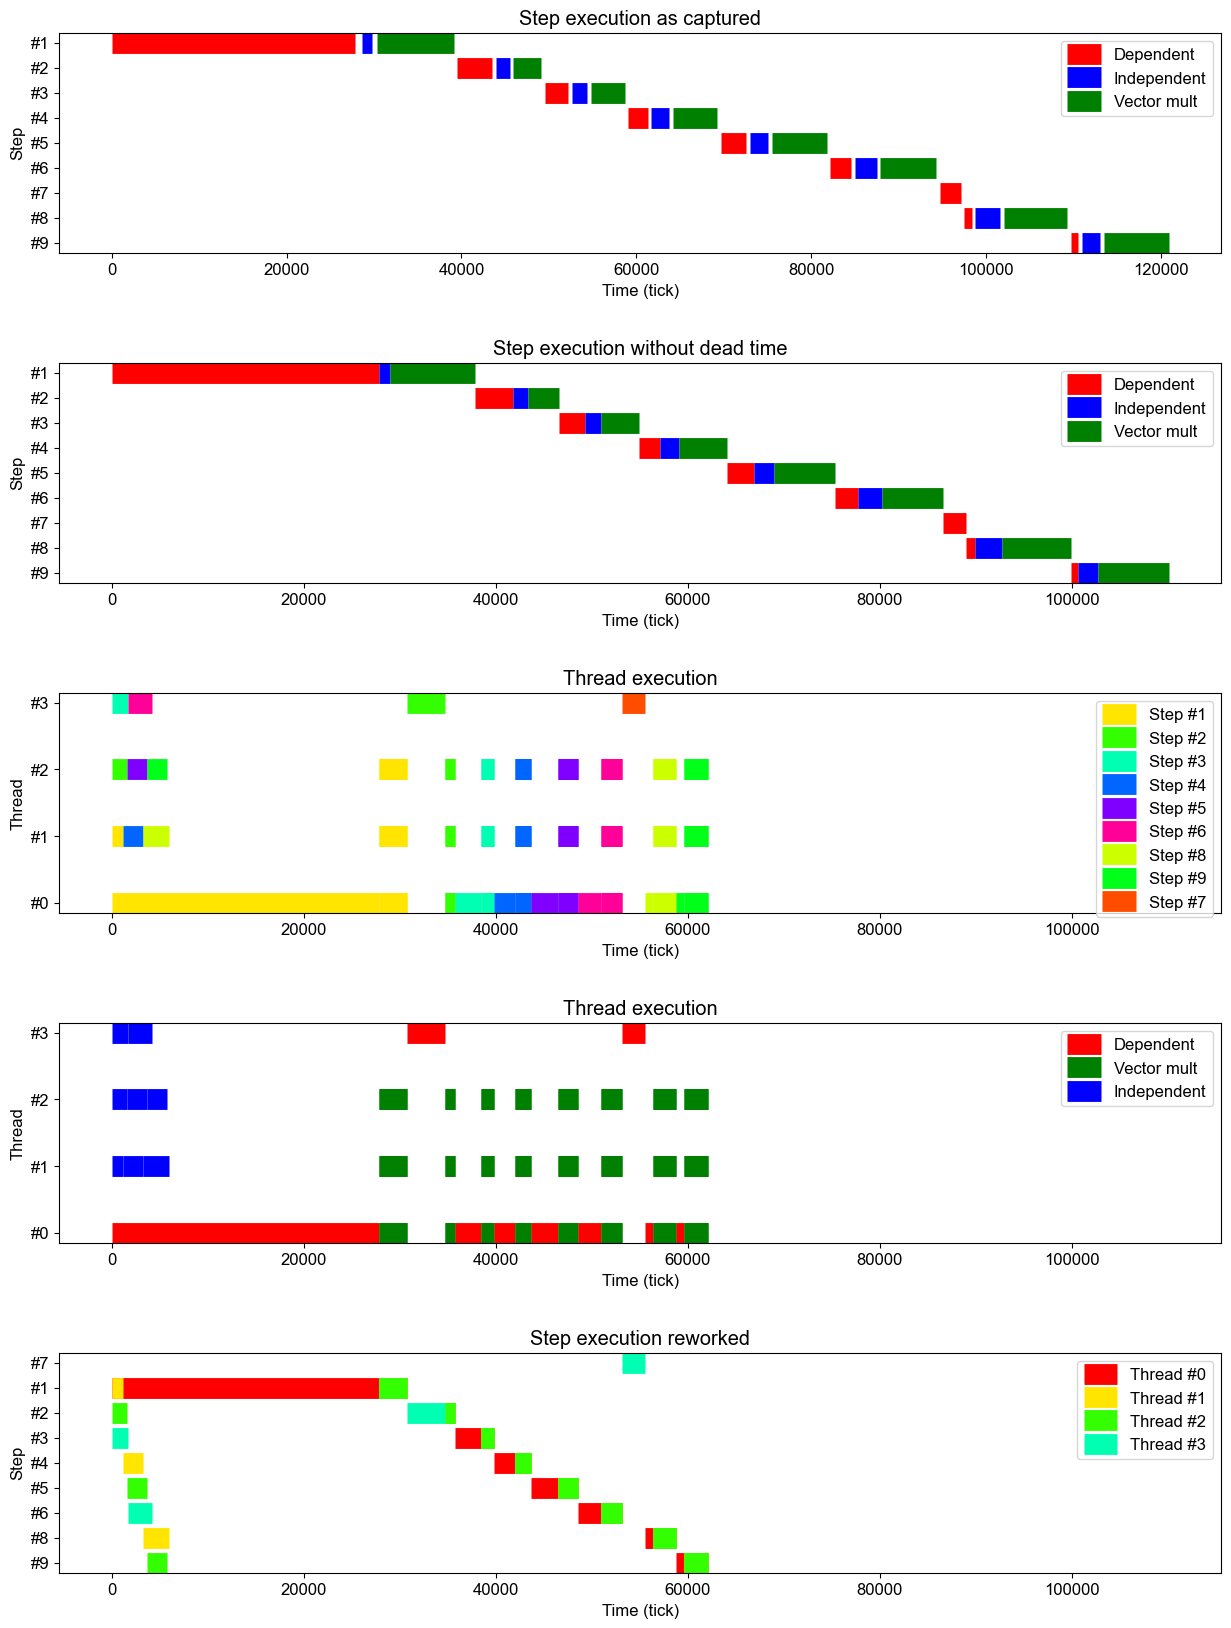

In [115]:
start_state = [0.1, 0.1, 0.1]
step = 1

new_logger = Logger()
dormandPrinceIsolated(step, start_state, lorenz, new_logger)
new_logger.show()

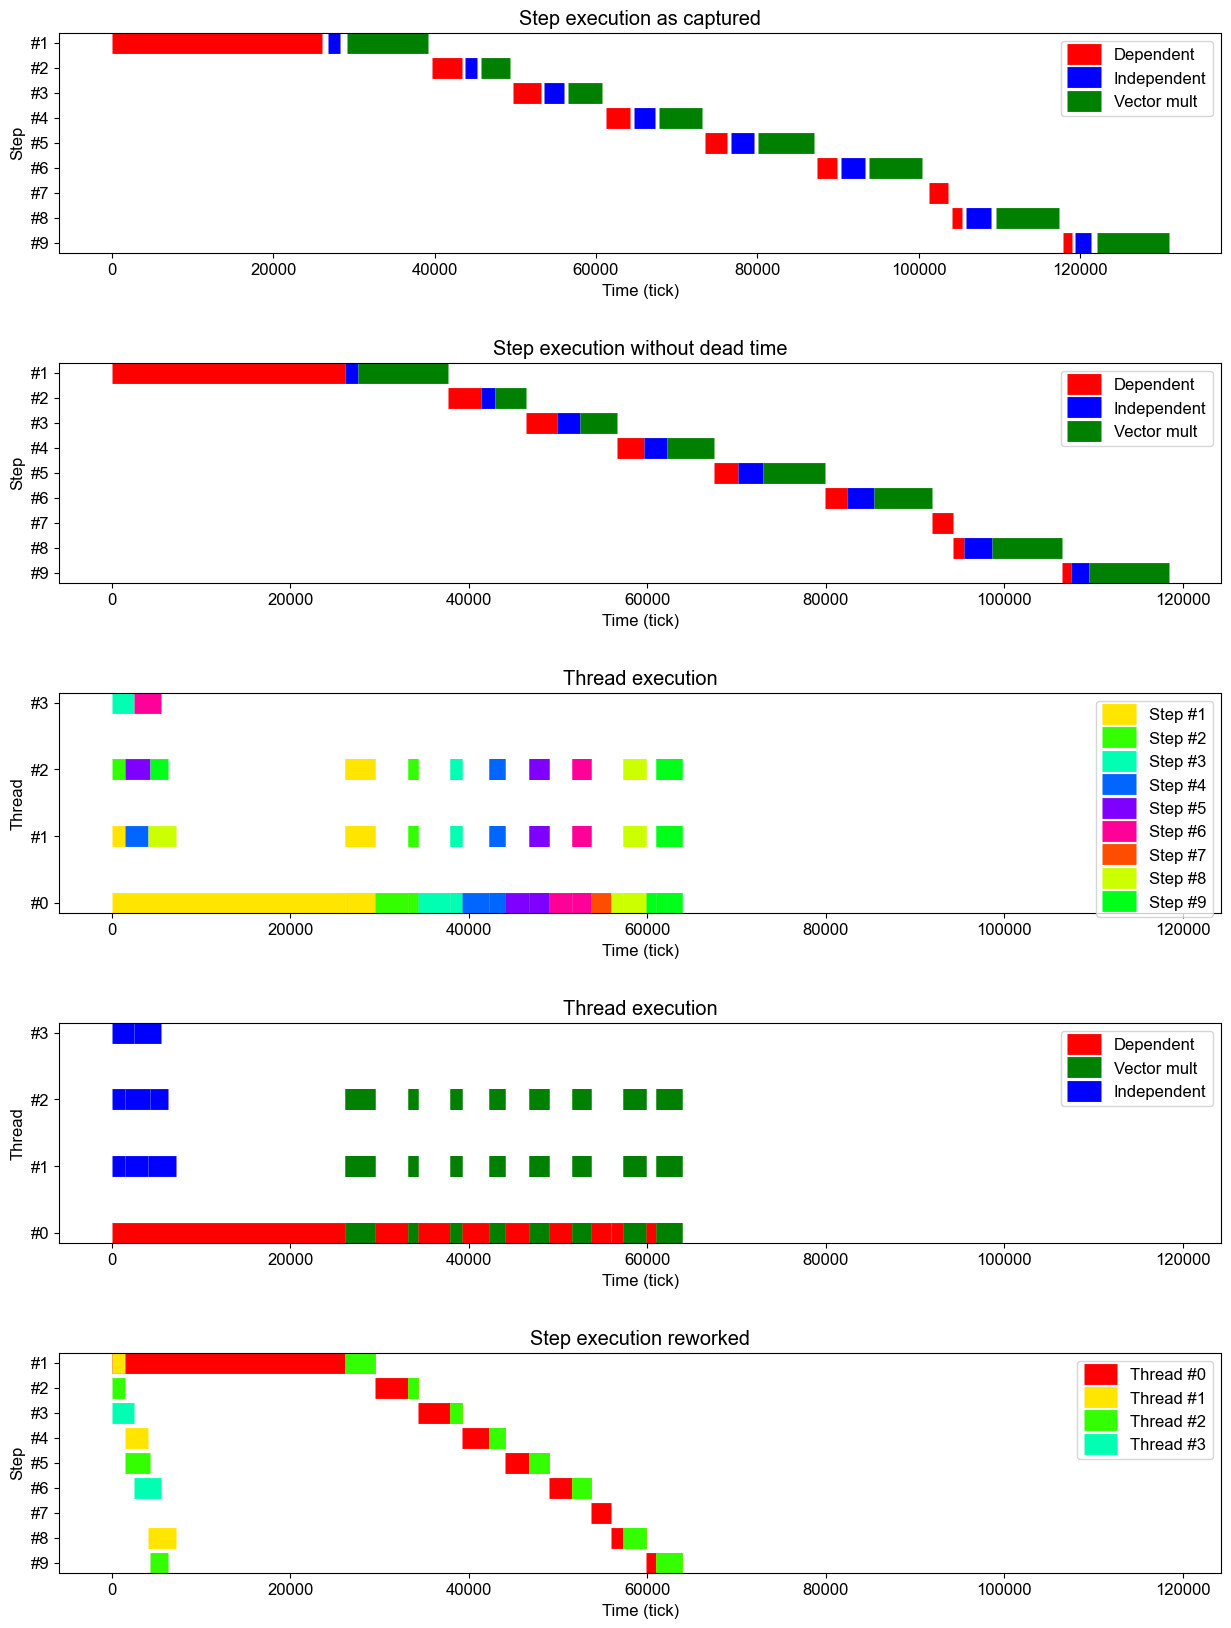

In [116]:
start_state = [0.1, 0.1, 0.1]
step = 1
new_logger = Logger()
dormandPrinceIsolated(step, start_state, simple, new_logger)
new_logger.show()